In [40]:
# INSTALL DEPENDENCIES
!pip install -U pandas numpy scikit-learn nltk matplotlib seaborn
!pip install -U torch torchvision torchaudio
!pip install -U transformers datasets accelerate sentencepiece
!pip install -U wordcloud gensim bertopic umap-learn hdbscan

  Using cached numpy-2.4.2-cp313-cp313-win_amd64.whl.metadata (6.6 kB)
Using cached numpy-2.4.2-cp313-cp313-win_amd64.whl (12.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.3
    Uninstalling numpy-2.1.3:
      Successfully uninstalled numpy-2.1.3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.61.0 requires numpy<2.2,>=1.24, but you have numpy 2.4.2 which is incompatible.
streamlit 1.45.1 requires pandas<3,>=1.4.0, but you have pandas 3.0.0 which is incompatible.


  Using cached numpy-2.1.3-cp313-cp313-win_amd64.whl.metadata (60 kB)
Using cached numpy-2.1.3-cp313-cp313-win_amd64.whl (12.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.4.2
    Uninstalling numpy-2.4.2:
      Successfully uninstalled numpy-2.4.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.45.1 requires pandas<3,>=1.4.0, but you have pandas 3.0.0 which is incompatible.


In [41]:
# IMPORT LIBRARIES
import re
import random
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, roc_auc_score, roc_curve
)
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from transformers import DistilBertForSequenceClassification, logging

from sklearn.decomposition import LatentDirichletAllocation, NMF

import nltk
from nltk.corpus import stopwords, wordnet
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud

from datasets import Dataset
from transformers import (
    BertTokenizerFast, BertForSequenceClassification,
    RobertaTokenizerFast, RobertaForSequenceClassification,
    DistilBertTokenizerFast, DistilBertForSequenceClassification,
    Trainer, TrainingArguments, DataCollatorWithPadding
)

from bertopic import BERTopic

In [42]:
# NLTK DOWNLOADS & SEED
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("averaged_perceptron_tagger")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lapto\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lapto\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lapto\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\lapto\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [43]:
# LOAD DATASET
df = pd.read_csv(
    "amazon_cells_labelled.txt",
    sep="\t",
    header=None,
    names=["text", "label"]
)

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
print("Dataset size:", df.shape)
df.head(10)

Dataset size: (1000, 2)


,text,label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
5,I have to jiggle the plug to get it to line up...,0
6,If you have several dozen or several hundred c...,0
7,If you are Razr owner...you must have this!,1
8,"Needless to say, I wasted my money.",0
9,What a waste of money and time!.,0


In [44]:
# TEXT PREPROCESSING
STOPWORDS = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag):
    if tag.startswith("J"): return wordnet.ADJ
    if tag.startswith("V"): return wordnet.VERB
    if tag.startswith("N"): return wordnet.NOUN
    if tag.startswith("R"): return wordnet.ADV
    return wordnet.NOUN

def preprocess_text(text):
    text = re.sub(r"[^\w\s]", " ", text)
    text = re.sub(r"\d+", " ", text)
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in STOPWORDS and len(t) > 1]
    tokens = [
        lemmatizer.lemmatize(word, get_wordnet_pos(pos))
        for word, pos in pos_tag(tokens)
    ]
    return " ".join(tokens)

df["text_clean"] = df["text"].apply(preprocess_text)

In [45]:
# Applying Preprocessing
df["text_clean"] = df["text"].apply(preprocess_text)

df[["text", "text_clean"]].head(10)

,text,text_clean
0,So there is no way for me to plug it in here i...,way plug u unless go converter
1,"Good case, Excellent value.",good case excellent value
2,Great for the jawbone.,great jawbone
3,Tied to charger for conversations lasting more...,tie charger conversation last minute major pro...
4,The mic is great.,mic great
5,I have to jiggle the plug to get it to line up...,jiggle plug get line right get decent volume
6,If you have several dozen or several hundred c...,several dozen several hundred contact imagine ...
7,If you are Razr owner...you must have this!,razr owner must
8,"Needless to say, I wasted my money.",needless say waste money
9,What a waste of money and time!.,waste money time


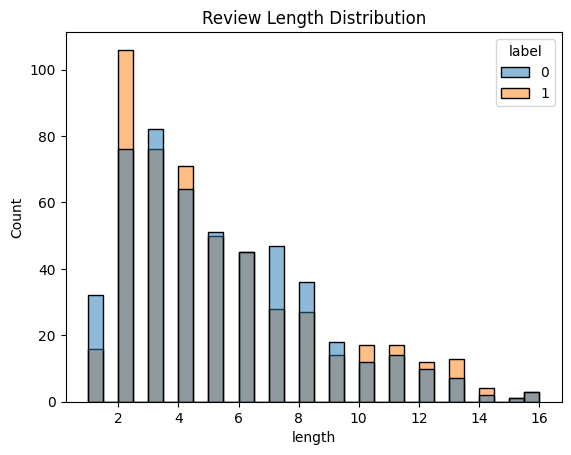

In [46]:
# VISUALISATIONS (PREPROCESSING)
df["length"] = df["text_clean"].apply(lambda x: len(x.split()))

plt.figure()
sns.histplot(data=df, x="length", hue="label", bins=30)
plt.title("Review Length Distribution")
plt.show()

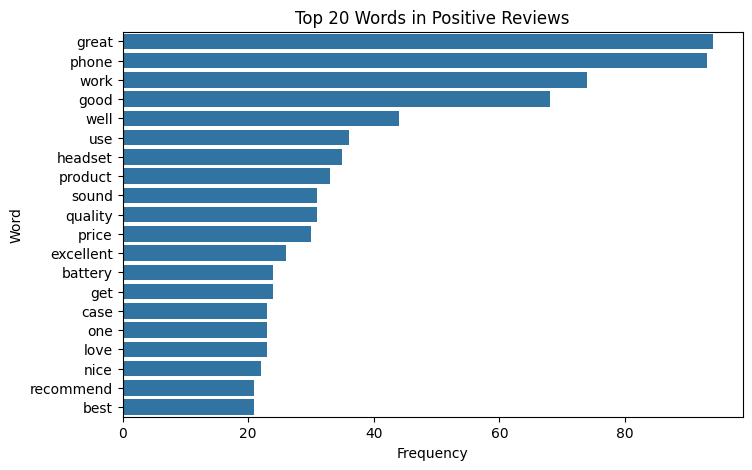

In [47]:
# TOP 20 WORDS IN POSITIVE REVIEWS
positive_words = " ".join(df[df["label"] == 1]["text_clean"]).split()
positive_freq = Counter(positive_words).most_common(20)

pos_df = pd.DataFrame(positive_freq, columns=["Word", "Frequency"])

plt.figure(figsize=(8,5))
sns.barplot(data=pos_df, x="Frequency", y="Word")
plt.title("Top 20 Words in Positive Reviews")
plt.show()

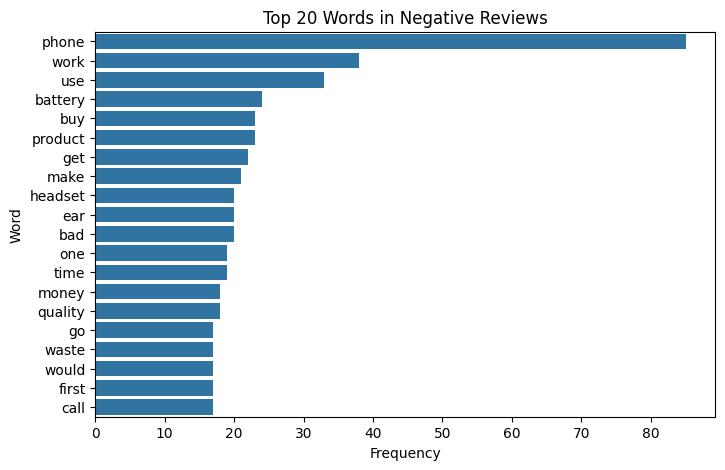

In [48]:
# TOP 20 WORDS IN NEGATIVE REVIEWS 
negative_words = " ".join(df[df["label"] == 0]["text_clean"]).split()
negative_freq = Counter(negative_words).most_common(20)

neg_df = pd.DataFrame(negative_freq, columns=["Word", "Frequency"])

plt.figure(figsize=(8,5))
sns.barplot(data=neg_df, x="Frequency", y="Word")
plt.title("Top 20 Words in Negative Reviews")
plt.show()

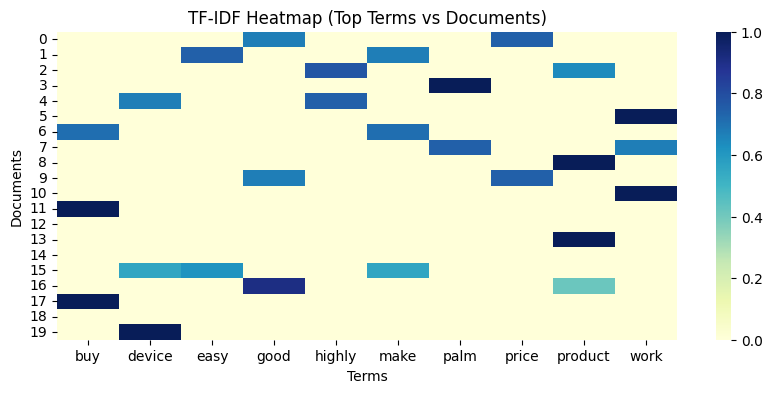

In [49]:
# USE A SMALL SAMPLE FOR READABILITY
sample_df = df.sample(20, random_state=SEED)

tfidf = TfidfVectorizer(max_features=10)
tfidf_matrix = tfidf.fit_transform(sample_df["text_clean"])

tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=tfidf.get_feature_names_out()
)

plt.figure(figsize=(10,4))
sns.heatmap(tfidf_df, cmap="YlGnBu")
plt.title("TF-IDF Heatmap (Top Terms vs Documents)")
plt.xlabel("Terms")
plt.ylabel("Documents")
plt.show()

In [50]:
# TRAIN-TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    df["text_clean"], df["label"],
    test_size=0.2, stratify=df["label"], random_state=SEED
)


Logistic Regression
Accuracy: 0.775
              precision    recall  f1-score   support

           0       0.78      0.77      0.77       100
           1       0.77      0.78      0.78       100

    accuracy                           0.78       200
   macro avg       0.78      0.78      0.77       200
weighted avg       0.78      0.78      0.77       200



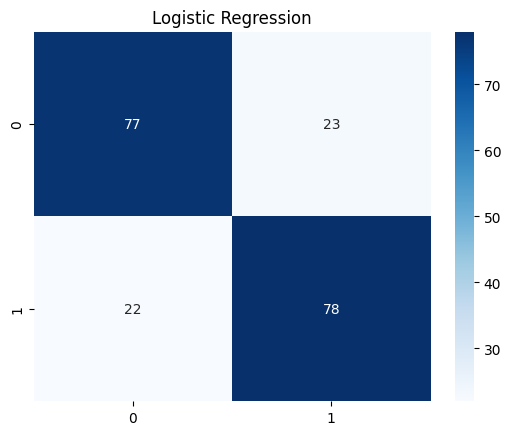


Linear SVM
Accuracy: 0.83
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       100
           1       0.82      0.84      0.83       100

    accuracy                           0.83       200
   macro avg       0.83      0.83      0.83       200
weighted avg       0.83      0.83      0.83       200



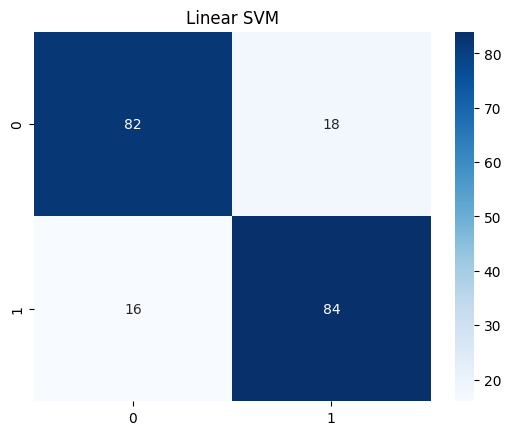


Naive Bayes
Accuracy: 0.795
              precision    recall  f1-score   support

           0       0.85      0.72      0.78       100
           1       0.76      0.87      0.81       100

    accuracy                           0.80       200
   macro avg       0.80      0.79      0.79       200
weighted avg       0.80      0.80      0.79       200



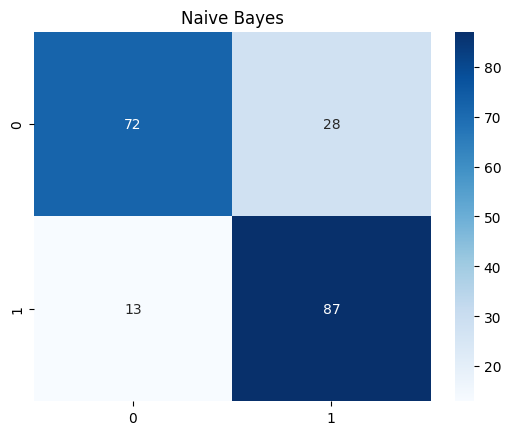


Random Forest
Accuracy: 0.745
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       100
           1       0.76      0.72      0.74       100

    accuracy                           0.74       200
   macro avg       0.75      0.74      0.74       200
weighted avg       0.75      0.74      0.74       200



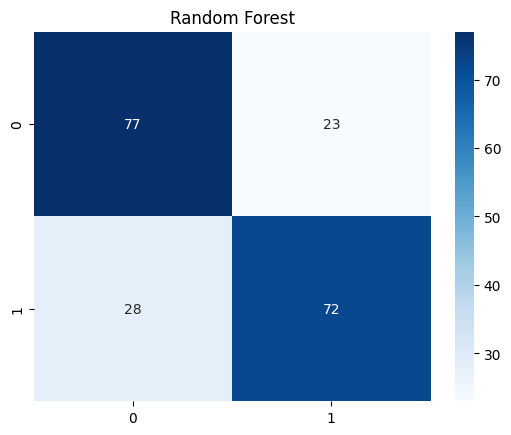


Gradient Boosting
Accuracy: 0.75
              precision    recall  f1-score   support

           0       0.72      0.81      0.76       100
           1       0.78      0.69      0.73       100

    accuracy                           0.75       200
   macro avg       0.75      0.75      0.75       200
weighted avg       0.75      0.75      0.75       200



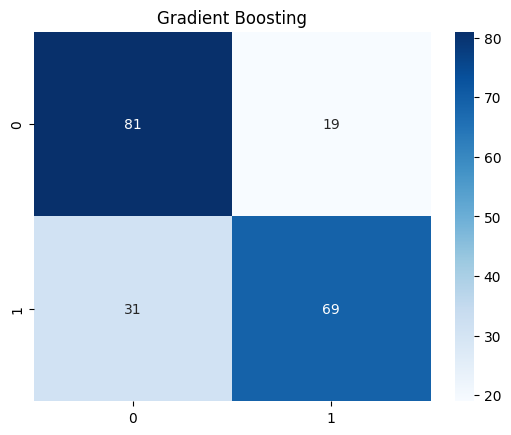


KNN
Accuracy: 0.75
              precision    recall  f1-score   support

           0       0.82      0.64      0.72       100
           1       0.70      0.86      0.77       100

    accuracy                           0.75       200
   macro avg       0.76      0.75      0.75       200
weighted avg       0.76      0.75      0.75       200



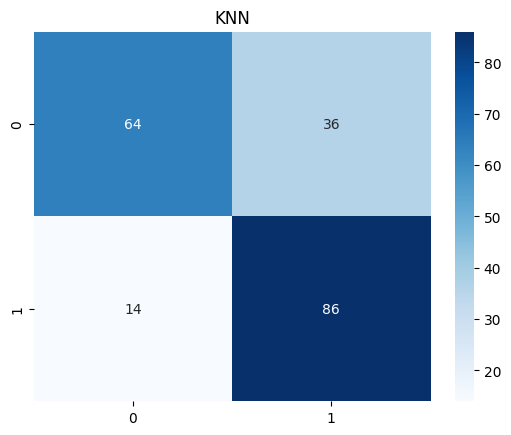

In [51]:
# BAG-OF-WORDS MODELS
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear SVM": LinearSVC(),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=200),
    "Gradient Boosting": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier(n_neighbors=7)
}

results = {}

for name, model in models.items():
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(ngram_range=(1,2), max_df=0.9)),
        ("clf", model)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

    print(f"\n{name}")
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred))

    sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True, fmt="d", cmap="Blues")
    plt.title(name)
    plt.show()

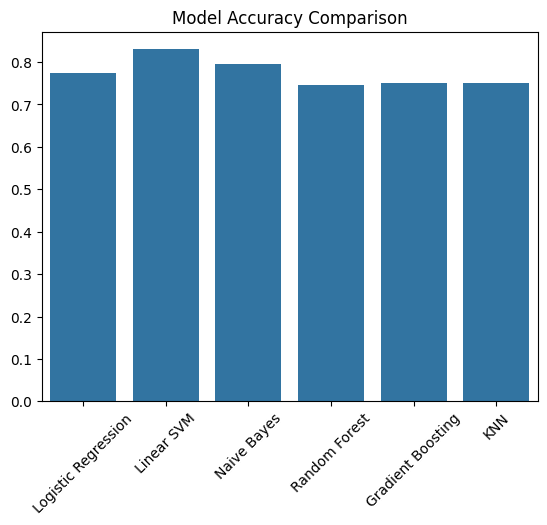

In [52]:
# MODEL COMPARISON VISUAL
plt.figure()
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.xticks(rotation=45)
plt.title("Model Accuracy Comparison")
plt.show()

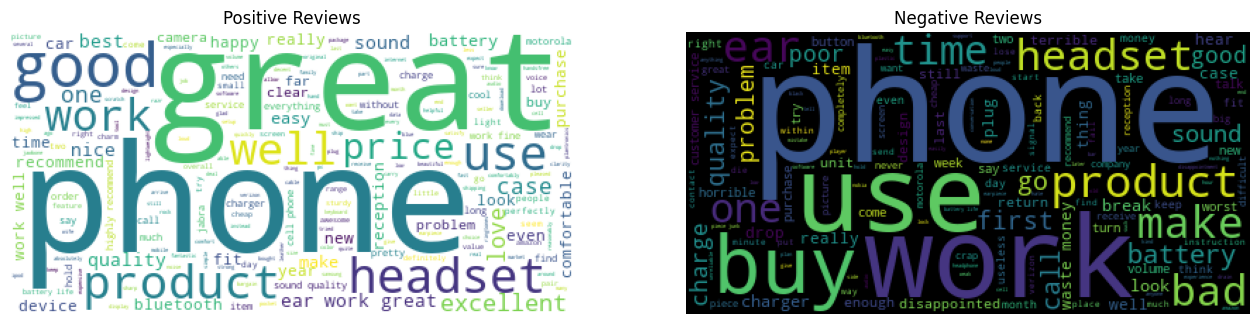

In [53]:
# WORD CLOUDS
positive = " ".join(df[df.label == 1]["text_clean"])
negative = " ".join(df[df.label == 0]["text_clean"])

fig, ax = plt.subplots(1,2, figsize=(16,6))
ax[0].imshow(WordCloud(background_color="white").generate(positive))
ax[0].set_title("Positive Reviews")
ax[0].axis("off")

ax[1].imshow(WordCloud(background_color="black").generate(negative))
ax[1].set_title("Negative Reviews")
ax[1].axis("off")
plt.show()

In [54]:
# BERT FINE-TUNING
# Preparing Hugging Face Dataset
hf_df = df[["text", "label"]]
dataset = Dataset.from_pandas(hf_df)

dataset = dataset.train_test_split(test_size=0.2, seed=SEED)

In [55]:
# TOKENIZATION
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

def tokenize_batch(batch):
    return tokenizer(batch["text"], truncation=True)

tokenized_dataset = dataset.map(tokenize_batch, batched=True)

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [56]:
def train_transformer(model_name, tokenizer_cls, model_cls):
    tokenizer = tokenizer_cls.from_pretrained(model_name)
    model = model_cls.from_pretrained(model_name, num_labels=2)

    def tokenize(batch):
        return tokenizer(batch["text"], truncation=True)

    tokenized = dataset.map(tokenize, batched=True)

    args = TrainingArguments(
        output_dir=f"./{model_name}_results",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=2,
        eval_strategy="epoch",
        save_strategy="no",
        logging_steps=50,
        seed=SEED,
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized["train"],
        eval_dataset=tokenized["test"],
        data_collator=DataCollatorWithPadding(tokenizer)
    )

    trainer.train()
    return trainer.evaluate()

In [57]:
logging.set_verbosity_error()

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2,
    ignore_mismatched_sizes=True
)

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

In [58]:
bert_results = train_transformer(
    "bert-base-uncased",
    BertTokenizerFast,
    BertForSequenceClassification
)

roberta_results = train_transformer(
    "roberta-base",
    RobertaTokenizerFast,
    RobertaForSequenceClassification
)

distilbert_results = train_transformer(
    "distilbert-base-uncased",
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification
)

print("BERT:", bert_results)
print("RoBERTa:", roberta_results)
print("DistilBERT:", distilbert_results)

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

{'loss': '0.3764', 'grad_norm': '2.033', 'learning_rate': '2.55e-05', 'epoch': '1'}
{'eval_loss': '0.1956', 'eval_runtime': '9.926', 'eval_samples_per_second': '20.15', 'eval_steps_per_second': '1.31', 'epoch': '1'}
{'loss': '0.1356', 'grad_norm': '8.01', 'learning_rate': '5e-07', 'epoch': '2'}
{'eval_loss': '0.2197', 'eval_runtime': '7.949', 'eval_samples_per_second': '25.16', 'eval_steps_per_second': '1.635', 'epoch': '2'}
{'train_runtime': '272.9', 'train_samples_per_second': '5.863', 'train_steps_per_second': '0.366', 'train_loss': '0.256', 'epoch': '2'}
{'eval_loss': '0.2197', 'eval_runtime': '8.537', 'eval_samples_per_second': '23.43', 'eval_steps_per_second': '1.523', 'epoch': '2'}


Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

{'loss': '0.6986', 'grad_norm': '3.44', 'learning_rate': '2.55e-05', 'epoch': '1'}
{'eval_loss': '0.7094', 'eval_runtime': '27.29', 'eval_samples_per_second': '7.329', 'eval_steps_per_second': '0.476', 'epoch': '1'}
{'loss': '0.6999', 'grad_norm': '3.767', 'learning_rate': '5e-07', 'epoch': '2'}
{'eval_loss': '0.6941', 'eval_runtime': '34.21', 'eval_samples_per_second': '5.846', 'eval_steps_per_second': '0.38', 'epoch': '2'}
{'train_runtime': '920.2', 'train_samples_per_second': '1.739', 'train_steps_per_second': '0.109', 'train_loss': '0.6993', 'epoch': '2'}
{'eval_loss': '0.6941', 'eval_runtime': '32.36', 'eval_samples_per_second': '6.18', 'eval_steps_per_second': '0.402', 'epoch': '2'}


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

{'loss': '0.4206', 'grad_norm': '11.05', 'learning_rate': '2.55e-05', 'epoch': '1'}
{'eval_loss': '0.2527', 'eval_runtime': '5.413', 'eval_samples_per_second': '36.95', 'eval_steps_per_second': '2.401', 'epoch': '1'}
{'loss': '0.1339', 'grad_norm': '1.249', 'learning_rate': '5e-07', 'epoch': '2'}
{'eval_loss': '0.2497', 'eval_runtime': '5.835', 'eval_samples_per_second': '34.27', 'eval_steps_per_second': '2.228', 'epoch': '2'}
{'train_runtime': '172.2', 'train_samples_per_second': '9.291', 'train_steps_per_second': '0.581', 'train_loss': '0.2772', 'epoch': '2'}
{'eval_loss': '0.2497', 'eval_runtime': '5.976', 'eval_samples_per_second': '33.47', 'eval_steps_per_second': '2.175', 'epoch': '2'}
BERT: {'eval_loss': 0.2197020947933197, 'eval_runtime': 8.5368, 'eval_samples_per_second': 23.428, 'eval_steps_per_second': 1.523, 'epoch': 2.0}
RoBERTa: {'eval_loss': 0.694104015827179, 'eval_runtime': 32.3639, 'eval_samples_per_second': 6.18, 'eval_steps_per_second': 0.402, 'epoch': 2.0}
DistilBE

In [59]:
# TOPIC MODELLING
cv = CountVectorizer(max_df=0.9, min_df=10)
dtm = cv.fit_transform(df["text_clean"])

lda = LatentDirichletAllocation(n_components=10, random_state=SEED)
lda.fit(dtm)

feature_names = cv.get_feature_names_out()

for i, topic in enumerate(lda.components_):
    print(f"\nTopic {i+1}:",
          [feature_names[j] for j in topic.argsort()[-10:]])


Topic 1: ['headset', 'great', 'poor', 'purchase', 'good', 'product', 'excellent', 'price', 'sound', 'quality']

Topic 2: ['also', 'terrible', 'product', 'think', 'easy', 'first', 'love', 'ear', 'service', 'use']

Topic 3: ['lot', 'come', 'week', 'last', 'life', 'try', 'long', 'device', 'problem', 'battery']

Topic 4: ['still', 'reception', 'wear', 'could', 'say', 'comfortable', 'bluetooth', 'time', 'headset', 'get']

Topic 5: ['item', 'right', 'people', 'find', 'go', 'hear', 'waste', 'money', 'recommend', 'would']

Topic 6: ['two', 'easy', 'hold', 'product', 'car', 'charge', 'buy', 'make', 'well', 'good']

Topic 7: ['button', 'ever', 'far', 'month', 'picture', 'use', 'cell', 'best', 'like', 'one']

Topic 8: ['screen', 'camera', 'also', 'take', 'year', 'call', 'drop', 'great', 'bad', 'phone']

Topic 9: ['plug', 'well', 'ear', 'piece', 'break', 'nice', 'good', 'fit', 'case', 'really']

Topic 10: ['nice', 'keep', 'cheap', 'fine', 'charger', 'item', 'new', 'look', 'great', 'work']


In [60]:
tfidf = TfidfVectorizer(max_df=0.9, min_df=10)
tfidf_dtm = tfidf.fit_transform(df["text_clean"])

nmf = NMF(n_components=10, random_state=SEED)
nmf.fit(tfidf_dtm)

terms = tfidf.get_feature_names_out()

for i, topic in enumerate(nmf.components_):
    print(f"\nNMF Topic {i+1}:",
          [terms[j] for j in topic.argsort()[-10:]])


NMF Topic 1: ['two', 'say', 'also', 'best', 'ever', 'new', 'cell', 'like', 'buy', 'phone']

NMF Topic 2: ['new', 'time', 'plug', 'item', 'like', 'charger', 'one', 'fine', 'well', 'work']

NMF Topic 3: ['problem', 'look', 'also', 'year', 'service', 'reception', 'item', 'device', 'price', 'great']

NMF Topic 4: ['camera', 'quality', 'far', 'reception', 'really', 'nice', 'look', 'case', 'price', 'good']

NMF Topic 5: ['comfortable', 'one', 'bluetooth', 'like', 'best', 'love', 'easy', 'ear', 'headset', 'use']

NMF Topic 6: ['go', 'well', 'ear', 'happy', 'find', 'first', 'price', 'excellent', 'buy', 'product']

NMF Topic 7: ['service', 'take', 'disappointed', 'last', 'go', 'charge', 'long', 'buy', 'life', 'battery']

NMF Topic 8: ['problem', 'drop', 'really', 'screen', 'call', 'could', 'waste', 'reception', 'money', 'get']

NMF Topic 9: ['case', 'service', 'clear', 'excellent', 'call', 'poor', 'make', 'well', 'sound', 'quality']

NMF Topic 10: ['really', 'also', 'bad', 'purchase', 'one', '

In [61]:
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(df["text_clean"])

topic_model.get_topic_info()

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

,Topic,Count,Name,Representation,Representative_Docs
0,-1,270,-1_phone_work_get_call,"[phone, work, get, call, use, great, verizon, ...",[pair two device easy barely take couple minut...
1,0,96,0_quality_look_design_nice,"[quality, look, design, nice, easy, fit, poor,...","[look nice, well design sharp blue nice color,..."
2,1,59,1_headset_headphone_bluetooth_best,"[headset, headphone, bluetooth, best, sound, u...","[best headset ever, excellent bluetooth headse..."
3,2,50,2_camera_button_picture_keyboard,"[camera, button, picture, keyboard, belt, clip...",[pro good camera nice picture also cool style ...
4,3,47,3_ear_jabra_fit_comfortable,"[ear, jabra, fit, comfortable, earpiece, comfo...","[jabra eargels fit ear well, comfortable ear, ..."
5,4,42,4_battery_life_original_long,"[battery, life, original, long, die, extend, r...","[battery life also great, battery work great, ..."
6,5,42,5_sound_quality_volume_audio,"[sound, quality, volume, audio, hear, poor, cl...","[excellent sound quality, poor sound quality, ..."
7,6,32,6_product_happy_item_good,"[product, happy, item, good, far, pleased, imp...","[great product, happy product, happy product]"
8,7,29,7_charger_charge_car_plug,"[charger, charge, car, plug, adapter, power, c...",[stupid keep buy new charger car charger cradl...
9,8,29,8_price_good_deal_worth,"[price, good, deal, worth, product, amazon, gr...","[great price, good price, price good]"
